# Daily Climate time series data analysis

## Config

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-40e49d7d-28f8-2e42-5423-abd4e1b056f4)


## Data loading

In [4]:
# Parse dates and set date column to index
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv",
                       parse_dates=["date"],
                       index_col=["date"])
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv",
                      parse_dates=["date"],
                      index_col=["date"])

## Data vizualisation

In [5]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [10]:
train_df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

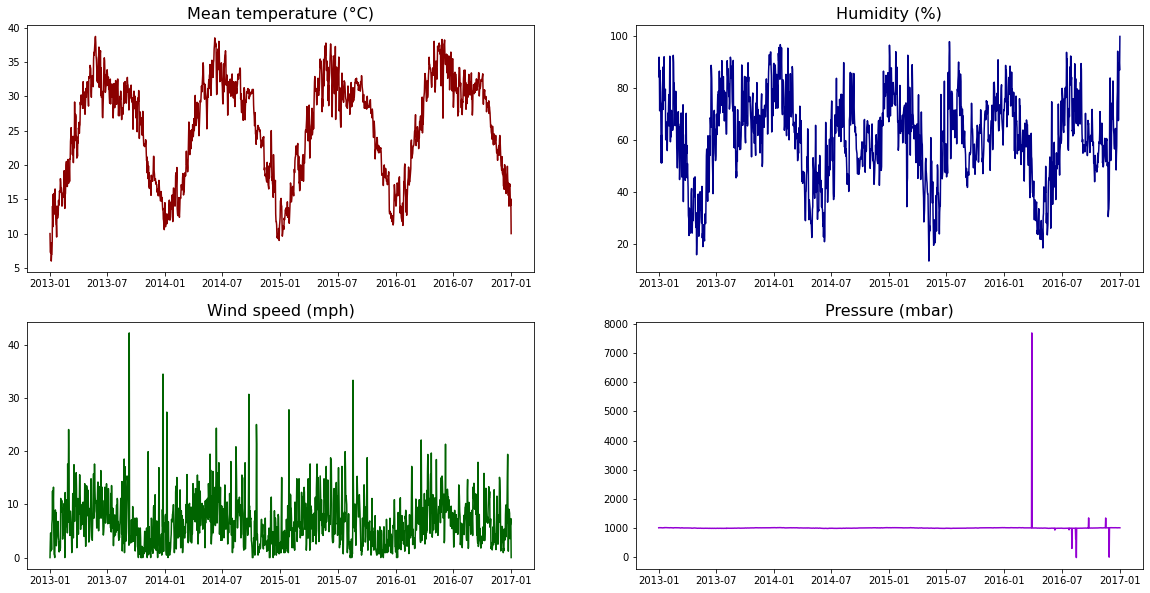

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
ax1.plot(train_df.index, train_df["meantemp"], c='darkred')
ax1.set_title("Mean temperature (°C)", fontsize=16)

ax2.plot(train_df.index, train_df["humidity"], c='darkblue')
ax2.set_title("Humidity (%)", fontsize=16)

ax3.plot(train_df.index, train_df["wind_speed"], c='darkgreen')
ax3.set_title("Wind speed (mph)", fontsize=16)

ax4.plot(train_df.index, train_df["meanpressure"], c='darkviolet')
ax4.set_title("Pressure (mbar)", fontsize=16)

fig.savefig('./graphs/all_air_data_curves.png');